# Modeling profitability (binary classification)

## Imports

In [40]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [2]:
df = pd.read_csv('/Users/ryanrappa/Desktop/dsi/film-profit-prediction/csv_files/clean_data_v2.csv')

## Dropping non-numerical and unnecessary cols

In [3]:
df.head()

,Unnamed: 0,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western
0,0,4000000.0,5,1995-12-09,4300000.0,98.0,Four Rooms,Crime,300000.0,1,Tim Roth,Antonio Banderas,Jennifer Beals,Madonna,Marisa Tomei,Allison Anders,Allison Anders,30,5.238649e+07,3.573649e+07,9.0,5.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.017498e+08,7.562609e+07,15.166667,9.333333,4.046212e+07,2.647601e+07,1.833333,1.000000,1.744469e+07,8.161356e+06,1.333333,0.500000,2.219325e+07,2.619325e+07,12,1995,1990,winter,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,11000000.0,11,1977-05-25,775398007.0,121.0,Star Wars,Adventure,764398007.0,1,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Mayhew,Anthony Daniels,George Lucas,George Lucas,67,4.420000e+06,2.820000e+06,1.0,1.0,71218500.0,7.044150e+07,2.0,2.0,7.121850e+07,70441500.0,2.0,2.0,1.818402e+07,1.419652e+07,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.547333e+07,-4.526667e+06,1.000000,0.000000,2.681925e+07,3.781925e+07,5,1977,1970,summer,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,94000000.0,12,2003-05-30,940335536.0,100.0,Finding Nemo,Animation,846335536.0,1,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton,Andrew Stanton,62,6.991528e+07,4.389605e+07,15.0,9.0,0.0,0.000000e+00,0.0,0.0,4.744807e+08,366147328.0,3.0,3.0,7.257531e+07,3.761663e+07,13.600000,9.800000,3.538779e+07,2.266113e+07,1.400000,1.200000,3.469014e+07,2.580164e+07,0.700000,0.700000,-5.904236e+07,3.495764e+07,5,2003,2000,summer,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,55000000.0,13,1994-07-06,677945399.0,142.0,Forrest Gump,Comedy,622945399.0,1,Tom Hanks,Robin Wright,Gary Sinise,Mykelti Williamson,Sally Field,Robert Zemeckis,Eric Roth,39,5.077868e+07,3.707660e+07,14.0,12.0,192273625.0,1.551070e+08,6.0,6.0,0.000000e+00,0.0,0.0,0.0,7.807074e+07,6.059212e+07,13.142857,10.857143,4.421214e+07,3.217999e+07,1.142857,1.142857,1.145317e+08,9.707339e+07,1.571429,1.571429,6.652615e+07,1.215262e+08,7,1994,1990,summer,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,15000000.0,14,1999-09-15,356296601.0,122.0,American Beauty,Drama,341296601.0,1,Kevin Spacey,Annette Bening,Thora Birch,Wes Bentley,Mena Suvari,Sam Mendes,Alan Ball,54,5.776690e+07,2.069283e+07,16.0,12.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,6.881550e+07,4.022940e+07,11.666667,8.166667,1.988473e+07,8.995846e+06,0.500000,0.333333,7.765796e+07,6.334546e+07,0.666667,0.583333,1.388345e+07,2.888345e+07,9,1999,1990,fall,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
# Going to try modeling without competitor, because this probably makes things
# easier for end users who want to predict their film's potential profitability;
# it would probably be difficult for many end users to guess at competitor 
# metrics to input into the mode. Additionally,

# I noticed in EDA that the relationship btw competition and profit looks 
# random/non-existent. Also, when running logistic regression, I observed
# that including competitor metrics actually LOWERS accuracy

cols_X = ['runtime', 'releases', 'cast_rev', 'cast_prof', 'cast_films', 'cast_prof_films', 'dir_rev',
       'dir_prof', 'dir_films', 'dir_prof_films', 'writ_rev', 'writ_prof', 'writ_films',
       'writ_prof_films', 'adj_budget', 'cast_dir_avg_rev', 
       'fall', 'spring', 'summer', 'winter', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'None', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']
# , 'compet_cast_rev', 'compet_cast_prof', 'compet_cast_films',
#        'compet_cast_prof_films', 'compet_dir_rev', 'compet_dir_prof', 'compet_dir_films',
#        'compet_dir_prof_films', 'compet_writ_rev', 'compet_writ_prof', 'compet_writ_films',
#        'compet_writ_prof_films']

In [57]:
col_y = ['made_money']

In [58]:
X = df.loc[:, cols_X].values
y = df.loc[:, col_y].values

### Scaled data for use with logsitic regression, SVMs:`

In [59]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## Function to show confusion matrix, etc.

#### from: https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Accuracy =     {:.3f}'.format((tp+tn)/(tp+fp+tn+fn)))
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return (tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

## Train-test split & logistic regression

#### Data is imbalanced (has mostly profitable movies), so going to use stratified train-test split

In [61]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X_scaled, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


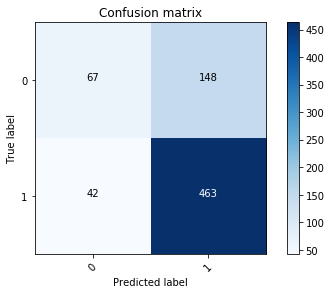

Accuracy =     0.736
Precision =     0.758
Recall (TPR) =  0.917
Fallout (FPR) = 6.884e-01


In [62]:
lrn = LogisticRegression(penalty='l1')

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)